In [28]:
# Import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

In [29]:
# Set device (automatically uses GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

Using device: cuda



In [30]:
# Load and preprocess data
transform = transforms.Compose([transforms.ToTensor()]) # Convert images to tensors and normalize pixel values to [0,1]
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform) # Download Fashion-MNIST dataset (60k training, 10k test images)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True) # Create data loaders for batch processing (64 images/batch)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [31]:
# Define model
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),            # Flatten 28x28 image to 784D vector
            nn.Linear(784, 256),     # Input layer (784 → 256 neurons)
            activation_fn(),         # Activation function (ReLU/Swish/etc.)
            nn.Linear(256, 10)       # Output layer (256 → 10 classes)
        )
    
    def forward(self, x):
        return self.layers(x)        # Forward pass

In [32]:
# Training function with loss tracking
def train_model(activation_fn):
    model = MLP(activation_fn).to(device)   # Initialize model, optimizer, and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    losses = []          # Track average loss per epoch
    start_time = time.time()
    
    print(f"Training with {activation_fn.__name__}...")
    for epoch in range(10):                                       # Training loop (10 epochs)
        epoch_loss = 0.0
        model.train()                                             # Set model to training mode
        for X, y in train_loader:                                 # Process data in batches
            X, y = X.to(device), y.to(device)                     # Move data to GPU/CPU
            optimizer.zero_grad()                                 # Reset gradients
            pred = model(X)                                       # Forward pass
            loss = criterion(pred, y)                             # Compute loss
            loss.backward()                                       # Backpropagation
            optimizer.step()                                      # Update weights
            epoch_loss += loss.item()                             # Accumulate loss
        
        avg_loss = epoch_loss / len(train_loader)                 # Calculate average epoch loss
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/10 - Loss: {avg_loss:.4f}")
    
    # Evaluate accuracy
    model.eval()                                                  # Set model to evaluation mode
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).sum().item()
    
    accuracy = correct / len(test_data) * 100
    return accuracy, time.time() - start_time, losses

In [33]:
# Compare activation functions
activation_fns = [("ReLU", nn.ReLU), ("Swish", nn.SiLU), ("Tanh", nn.Tanh), ("Sigmoid", nn.Sigmoid)]
results = {}

for name, fn in activation_fns:                                     # Train and evaluate all activation functions
    accuracy, time_taken, losses = train_model(fn)
    results[name] = {
        "accuracy": accuracy,
        "time": time_taken,
        "losses": losses
    }
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.1f}% | Time: {time_taken:.1f}s\n")

Training with ReLU...
Epoch 1/10 - Loss: 0.5195
Epoch 2/10 - Loss: 0.3809
Epoch 3/10 - Loss: 0.3386
Epoch 4/10 - Loss: 0.3117
Epoch 5/10 - Loss: 0.2959
Epoch 6/10 - Loss: 0.2805
Epoch 7/10 - Loss: 0.2642
Epoch 8/10 - Loss: 0.2551
Epoch 9/10 - Loss: 0.2445
Epoch 10/10 - Loss: 0.2363

ReLU Results:
Accuracy: 88.2% | Time: 83.8s

Training with SiLU...
Epoch 1/10 - Loss: 0.5199
Epoch 2/10 - Loss: 0.3759
Epoch 3/10 - Loss: 0.3364
Epoch 4/10 - Loss: 0.3076
Epoch 5/10 - Loss: 0.2862
Epoch 6/10 - Loss: 0.2697
Epoch 7/10 - Loss: 0.2533
Epoch 8/10 - Loss: 0.2410
Epoch 9/10 - Loss: 0.2290
Epoch 10/10 - Loss: 0.2185

Swish Results:
Accuracy: 88.5% | Time: 82.5s

Training with Tanh...
Epoch 1/10 - Loss: 0.4997
Epoch 2/10 - Loss: 0.3767
Epoch 3/10 - Loss: 0.3407
Epoch 4/10 - Loss: 0.3162
Epoch 5/10 - Loss: 0.2985
Epoch 6/10 - Loss: 0.2831
Epoch 7/10 - Loss: 0.2690
Epoch 8/10 - Loss: 0.2593
Epoch 9/10 - Loss: 0.2479
Epoch 10/10 - Loss: 0.2367

Tanh Results:
Accuracy: 86.5% | Time: 82.3s

Training wit

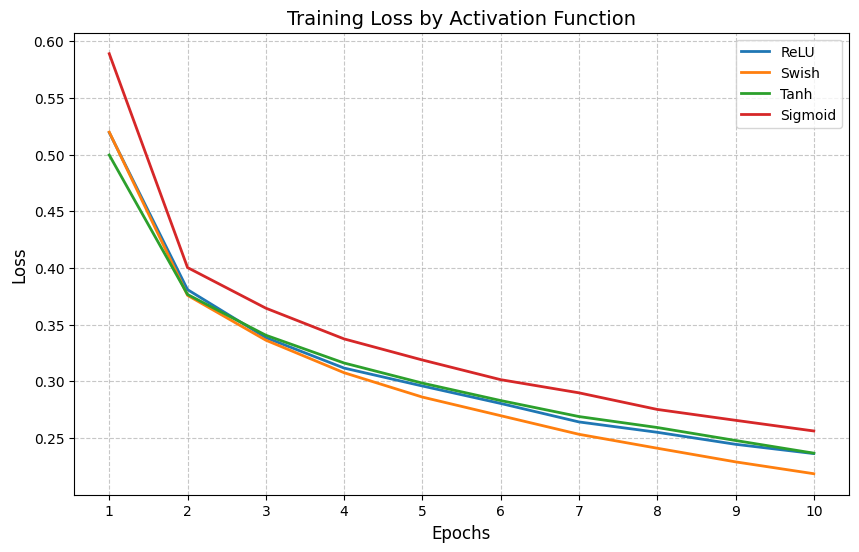

Plot saved as loss_curves.png!


In [34]:
# Visualization
plt.figure(figsize=(10, 6))
for name, data in results.items():
    epochs = range(1, 11)  # Explicitly define 10 epochs
    plt.plot(epochs, data['losses'], label=name, linewidth=2)

plt.title("Training Loss by Activation Function", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(range(1, 11))  # Force x-ticks to show 1-10
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as loss_curves.png!")